# House Prices: Advanced Regression Techniques

<blockquote>Predict sales prices and practice feature engineering, RFs, and gradient boosting</blockquote>

Competition [homepage](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [1]:
import math
import pandas as pd
import numpy as np
import os

from scipy.stats import uniform, randint

# Do not use normal form (scietific notation) when printing numbers, exponents can make it harder to compare values
pd.set_option('float_format', '{:f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns
#%pylab inline
# pylab.rcParams['figure.figsize'] = (15, 6)

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler

In [2]:
'numpy: {}, pandas: {}, sklearn: {}'.format(np.__version__, pd.__version__, sklearn.__version__)

'numpy: 1.14.5, pandas: 0.23.3, sklearn: 0.19.1'

## Import

In [3]:
competition_name = "house-prices-advanced-regression-techniques"
data_path = "..\datasets\kaggle\house-prices"

In [4]:
def read_data(filename):
    # although MSSubClass is represented as numeric the underlying feature is categorical
    return pd.read_csv(os.path.join(data_path, filename), index_col="Id", dtype={"MSSubClass": np.object})

In [5]:
train_data = read_data("train.csv")
test_data = read_data("test.csv")

In [6]:
X_train = train_data.drop(["SalePrice"], axis=1)
y_train = train_data["SalePrice"].copy()
X_test = test_data.copy()

## Explore

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.000000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.000000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.000000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.000000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
MSSubClass       1460 non-null object
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

In [11]:
X_train.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [12]:
X_train.describe(include=['O'])

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,15,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,20,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,536,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000180F6E29EB8>,
      dtype=object)

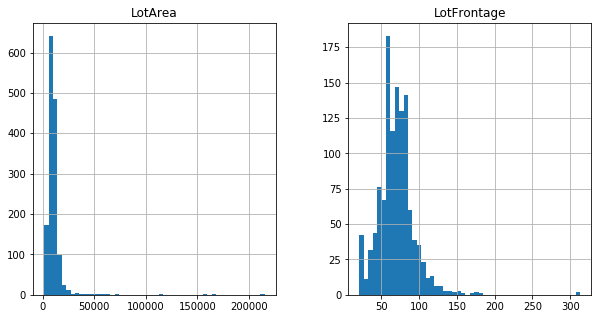

In [13]:
X_train[["LotArea", "LotFrontage"]].hist(bins=50, figsize=(10,5))

Look for correlations with the target value

In [14]:
corr_matrix = train_data.corr()

In [15]:
corr_matrix["SalePrice"].sort_values(ascending=False)[1:]

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [39]:
X_train["GarageQual"].value_counts()

TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [16]:
pd.reset_option('display.max_columns')

In [17]:
X_train.shape

(1460, 79)

## Transform

### Transformers

In [14]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """ Selects a set of columns from a DataFrame and returns a Numpy representation of the column values
    """
    
    def __init__(self, column_names=None):
        self.column_names = column_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.column_names].values

In [15]:
class DataFrameColumnSelector(BaseEstimator, TransformerMixin):
    """ Selects a set of columns from a DataFrame and returns a them as a DataFrame
    """
    
    def __init__(self, column_names=None):
        self.column_names = column_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.column_names]

In [16]:
class ExtendCategories(BaseEstimator, TransformerMixin):
    """Transformer that adds categories to DataFrame columns
    
    Intended use is the case where the categories in a series have been initialised based on the 
    initial values in the series, but the categories need to be extended before a new value can
    be added to the data, for example when filling NAs.  
    """
    
    def __init__(self, value):
        self.value=value
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(self.value, dict)
        assert isinstance(X, pd.DataFrame)
                
        for (column_name, cat_value) in self.value.items():
            X[column_name].cat.add_categories([cat_value], inplace=True)
        return X

In [17]:
class FillNaMostCommonTransformer(BaseEstimator, TransformerMixin):
    """Transformer that fills na with most common value
    
    If all values in a column are na column will be filled with the fallback value
    """    
    
    def __init__(self, fallback="EMPTY"):
        self.fallback=fallback
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.apply(lambda x: x.fillna(self.__getMostCommonValue(x)))
    
    def __getMostCommonValue(self, s):
        return s.value_counts().index[0] if s.any() else self.fallback

In [18]:
class FillnaTransformer(BaseEstimator, TransformerMixin):
    """Transformer that fills in NA values
    """
    
    def __init__(self, value):
        self.value=value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.fillna(self.value)

In [19]:
class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    """Transformer that one-hot encodes the given columns and outputs a DataFrame
    """
    
    def __init__(self, columns=None, drop_first=False):
        self.columns = columns
        self.drop_first=drop_first
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.get_dummies(X, columns=self.columns, drop_first=self.drop_first)

In [20]:
class ImputerTransformer(BaseEstimator, TransformerMixin):
    """Transformer that imputes missing values and outputs a DataFrame
    """    
    
    def __init__(self, strategy="mean"):
        self.strategy=strategy
        
    def fit(self, X, y=None):
        self.imputer = Imputer(strategy=self.strategy).fit(X)
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.DataFrame(self.imputer.transform(X), index=X.index, columns=X.columns)

In [21]:
from sklearn.preprocessing import PolynomialFeatures

class PolynomialTransformer(BaseEstimator, TransformerMixin):
    """Transformer that generate polynomial and interaction features
    
    Same behaviour as `PolynomialFeatures` but outputs a DataFrame.
    Although a DataFrame is output the column names are numeric, the input column names being lost in translation.
    
    To remove columns set `degree=0`
    For no-op set `degree=1` and `include_bias=False`
    """    
    
    def __init__(self, degree=2, interaction_only=False, include_bias=True):
        self.degree=degree
        self.interaction_only=interaction_only
        self.include_bias=include_bias
    
    def fit(self, X, y=None):
        self.polynomial = PolynomialFeatures(degree=self.degree, interaction_only=self.interaction_only, include_bias=self.include_bias).fit(X)
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        transformed=self.polynomial.transform(X)
        return pd.DataFrame(transformed, index=X.index)

In [64]:
class ReplaceValueTransformer(BaseEstimator, TransformerMixin):
    """Transformer that replaces values
    """
    
    def __init__(self, value):
        self.value = value
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        X.replace(self.value, inplace=True)
        return X

In [23]:
class ScalerTransformer(BaseEstimator, TransformerMixin):
    """Transformer that performs standard scaling
    
    Same behaviour as `StandardScaler` but outputs a DataFrame
    """    
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.scaler = StandardScaler().fit(X)
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.DataFrame(self.scaler.transform(X), index=X.index, columns=X.columns)

In [24]:
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    """Transformer that selects a set of columns
    """
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [25]:
class TypeSelector(BaseEstimator, TransformerMixin):
    """ Transformer that selects a number of DataFrame columns by type
    """
    
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [26]:
import numpy as np
import pandas as pd
from sklearn.externals.joblib import Parallel, delayed
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one
from scipy import sparse

class PandasFeatureUnion(FeatureUnion):
    """ Takes a number of pipelines, euns them in parallel and outputs a DataFrame
    
    Overrides `fit_transform` and `transform` from `FeatureUnion`, code is copied from the parent implementation
    with the only difference being the call to `merge_dataframes_by_column` in order to output a DataFrame
    rather than a Numpy array.
    
    From https://zablo.net/blog/post/pandas-dataframe-in-scikit-learn-feature-union
    """
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(trans, weight, X, y,
                                        **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, weight, X)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

### Pipelines

In [81]:
numeric_columns = [
    "LotFrontage",
    "LotArea",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MoSold",
    "YrSold"
]

ordinal_categorical_columns = [
    "OverallQual", 
    "OverallCond", 
    "BsmtQual", 
    "BsmtCond", 
    "BsmtExposure", 
    "BsmtFinType1", 
    "HeatingQC", 
    "KitchenQual", 
    "FireplaceQu", 
    "PoolQC", 
    "Fence"
]

nominal_categorical_columns = [
    "MSSubClass",
    "MSZoning",
    "Street",
    "Alley",
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "ExterQual",
    "ExterCond",
    "Foundation",
    "BsmtFinType2",
    "Heating",
    "CentralAir",
    "Electrical",
    "Functional",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "PavedDrive",
    "MiscFeature",
    "SaleType",
    "SaleCondition"
]

The object columns in the test and train sets contain different categories, so if we one-hot encode the two datasets we'll end up with transformed datasets that contain different numbers of columns, prediction on the test set will then fail. As a workaround we'll combine the test and train sets and one-hot encode the combined data, then split apart into train and test data again. That said, it does have the advantage of converting all data to numeric, removing the need for separate object and numeric pipelines.
This is not ideal as training involves knowledge of the test data, but it'll do for a Kaggle competition. 

In [127]:
from pandas.api.types import CategoricalDtype

all_data = pd.concat((X_train, X_test))

for column in all_data[nominal_categorical_columns].columns:
    unique_values = all_data[column].dropna().unique()
    
    X_train[column] = X_train[column].astype(CategoricalDtype(categories=unique_values))
    X_test[column] = X_test[column].astype(CategoricalDtype(categories=unique_values))

Pipeline to transform numeric columns

In [128]:
numeric_pipeline = Pipeline([
    ("select_number", DataFrameColumnSelector(column_names=numeric_columns)),
    ("impute_values", ImputerTransformer()),
    ("add_polynomial", PolynomialTransformer()),
    ("std_scaler", ScalerTransformer())
])

Pipeline to transform _ordinal_ categorical columns  
Convert text values to numeric and do not one-hot encode

In [129]:
# Many columns have NA values where the NA has some meaning, hence NA should not in these cases be replaced with the most common value.
# For example, a fence quality of NA means "No fence", not an unknown fence quality.
ordinal_significant_nas = { 
    "BsmtQual": "None",
    "BsmtCond": "None", 
    "BsmtExposure": "None", 
    "BsmtFinType1": "None", 
    "HeatingQC": "None", 
    "KitchenQual": "None", 
    "FireplaceQu": "None",
    "PoolQC": "None",     
    "Fence": "None" 
}

In [130]:
BsmtQual_categories = {
    "Ex": 6,
    "Gd": 5,
    "TA": 4,
    "Fa": 3,
    "Po": 2,
    "None": 1
}

BsmtCond_categories = {
    "Ex": 6,
    "Gd": 5,
    "TA": 4,
    "Fa": 3,
    "Po": 2,
    "None": 1
}

BsmtExposure_categories = {
    "Gd": 5,
    "Av": 4,
    "Mn": 3,
    "No": 2,
    "None": 1
}

BsmtFinType1_categories = {
    "GLQ": 7,
    "ALQ": 6,
    "BLQ": 5,
    "Rec": 4,
    "LwQ": 3,
    "Unf": 2,
    "None": 1
}

HeatingQC_categories = {
    "Ex": 6,
    "Gd": 5,
    "TA": 4,
    "Fa": 3,
    "Po": 2,
    "None": 1
}

KitchenQual_categories = {
    "Ex": 6,
    "Gd": 5,
    "TA": 4,
    "Fa": 3,
    "Po": 2,
    "None": 1
}

FireplaceQu_categories = {
    "Ex": 6,
    "Gd": 5,
    "TA": 4,
    "Fa": 3,
    "Po": 2,
    "None": 1
}

PoolQC_categories = {
    "Ex": 5,
    "Gd": 4,
    "TA": 3,
    "Fa": 2,
    "None": 1
}

Fence_categories = {
    "GdPrv": 5,
    "MnPrv": 4,
    "GdWo": 3,
    "MnWw": 2,
    "None": 1
}

value_replacements = {
    "BsmtQual": BsmtQual_categories,
    "BsmtCond": BsmtCond_categories,
    "BsmtExposure": BsmtExposure_categories,
    "BsmtFinType1": BsmtFinType1_categories,
    "HeatingQC": HeatingQC_categories,
    "KitchenQual": KitchenQual_categories,
    "FireplaceQu": FireplaceQu_categories,
    "PoolQC": PoolQC_categories,
    "Fence": Fence_categories
}

In [131]:
ordinal_categorical_pipeline = Pipeline([
    ("ordinal_categorical", DataFrameColumnSelector(column_names=ordinal_categorical_columns)),
    ("ordinal_fillna", FillnaTransformer(ordinal_significant_nas)),
    ("ordinal_replace", ReplaceValueTransformer(value_replacements)),
    ("ordinal_scale", ScalerTransformer())
])

Pipeline to transform _nominal_ categorical columns, one-hot encoded

In [132]:
# Many columns have NA values where the NA has some meaning, hence NA should not in these cases be replaced with the most common value.
# For example, a fence quality of NA means "No fence", not an unknown fence quality.
nominal_significant_nas = { 
    "Alley": "None",
    "GarageType": "None", 
    "GarageFinish": "None", 
    "GarageQual": "None", 
    "GarageCond": "None", 
    "MiscFeature": "None" 
}

nominal_categorical_pipeline = Pipeline([
    ("nominal_categorical", DataFrameColumnSelector(column_names=nominal_categorical_columns)),
    ("nominal_extend_categories", ExtendCategories(nominal_significant_nas)),
    ("nominal_fill_na", FillnaTransformer(significant_nas)),
    ("nominal_get_dummies", GetDummiesTransformer())
])

Run all pipelines in parallel and combine the results

In [133]:
transformation_pipeline = PandasFeatureUnion(transformer_list=[
    ("num_pipeline", numeric_pipeline),
    ("ord_cat_pipeline", ordinal_categorical_pipeline),
    ("nom_cat_pipeline", nominal_categorical_pipeline)
])

Verify the full transformation pipeline

In [134]:
X_train_transformed=transformation_pipeline.fit_transform(X_train)

In [135]:
X_train_transformed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,OverallQual,OverallCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,PoolQC,Fence,MSSubClass_60,MSSubClass_20,MSSubClass_70,MSSubClass_50,MSSubClass_190,MSSubClass_45,MSSubClass_90,MSSubClass_120,MSSubClass_30,MSSubClass_85,MSSubClass_80,MSSubClass_160,MSSubClass_75,MSSubClass_180,MSSubClass_40,MSSubClass_150,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,Street_Pave,Street_Grvl,Alley_Grvl,Alley_Pave,Alley_None,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Inside,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_Mitchel,Neighborhood_Somerst,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,Condition2_Norm,Condition2_Artery,Condition2_RRNn,Condition2_Feedr,Condition2_PosN,Condition2_PosA,Condition2_RRAn,Condition2_RRAe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5

In [136]:
X_train_transformed.shape

(1460, 841)

## Train

In [93]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, scores.mean(), scores.std()))

In [94]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

### Baseline

In [77]:
from sklearn.dummy import DummyRegressor

In [143]:
clf_dummy = DummyRegressor(strategy='median')

In [144]:
dummy_pipeline = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('clf_dummy', clf_dummy)
])

In [145]:
dummy_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('prepare_data', PandasFeatureUnion(n_jobs=1,
          transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('select_number', TypeSelector(dtype=<class 'numpy.number'>)), ('impute_values', ImputerTransformer(strategy='mean')), ('std_scaler', ScalerTransformer())])), ('cat_pip...rmer_weights=None)), ('clf_dummy', DummyRegressor(constant=None, quantile=None, strategy='median'))])

In [146]:
y_hat_dummy = dummy_pipeline.predict(X_test)

### LinearRegression

In [154]:
from sklearn.linear_model import LinearRegression

In [155]:
clf_lnr = LinearRegression()

In [156]:
pipeline_lnr = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('clf_linear', clf_lnr)
])

In [157]:
pipeline_lnr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('prepare_data', PandasFeatureUnion(n_jobs=1,
          transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('select_number', TypeSelector(dtype=<class 'numpy.number'>)), ('impute_values', ImputerTransformer(strategy='mean')), ('add_polynomial', PolynomialTransformer(degree=2...one)), ('clf_linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [158]:
y_hat_lnr = pipeline_lnr.predict(X_test)

In [159]:
scores_lnr = cross_val_score(pipeline_lnr, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
rmse_scores_lnr = np.sqrt(-scores_lnr)

In [160]:
display_scores(rmse_scores_lnr)

Scores: [342320.97578648 362445.77546214 110914.34700079 139540.12173397
 751494.30595283]
Mean: 341343.105
Std: 229125.356


### LinearSVR

Run a pipeline consisting of a transformation and a regression, with no hyperparameter searching.

In [161]:
from sklearn.svm import LinearSVR

In [162]:
clf_svr = LinearSVR(dual=True, random_state=42, tol=1e-4)

In [163]:
pipeline_svr = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('clf_svr', clf_svr)
])

In [164]:
pipeline_svr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('prepare_data', PandasFeatureUnion(n_jobs=1,
          transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('select_number', TypeSelector(dtype=<class 'numpy.number'>)), ('impute_values', ImputerTransformer(strategy='mean')), ('add_polynomial', PolynomialTransformer(degree=2...aling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0))])

In [165]:
y_hat_svr = pipeline_svr.predict(X_test)

In [166]:
scores_svr = cross_val_score(pipeline_svr, X_train, y_train, cv=5)

In [168]:
display_scores(scores_svr)

Scores: [-3.94853278 -3.38363674 -3.00309988 -3.81895593 -3.28866162]
Mean: -3.489
Std: 0.349


### Ridge

In [26]:
from sklearn.linear_model import Ridge

In [52]:
clf_ridge = Ridge(alpha=20)

pipeline_ridge = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('clf_ridge', clf_ridge)
])

pipeline_ridge.fit(X_train, y_train)

y_hat_ridge = pipeline_ridge.predict(X_test)

scores_ridge = cross_val_score(pipeline_ridge, X_train, y_train, cv=5)

In [53]:
display_scores(scores_ridge)

Scores: [0.90153924 0.83804604 0.8762273  0.88407202 0.70523564]
Mean: 0.84
Std: 0.07


### SGDRegressor

In [26]:
from sklearn.linear_model import SGDRegressor

clf_sgd = SGDRegressor(max_iter=1000, penalty="l2")

pipeline_sgd = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('clf_sgd', clf_sgd)
])

pipeline_sgd.fit(X_train, y_train)

y_hat_sgd = pipeline_sgd.predict(X_test)

scores_sgd = cross_val_score(pipeline_sgd, X_train, y_train, cv=5)

In [27]:
display_scores(scores_sgd)

Scores: [0.89019656 0.82129212 0.87165192 0.86620262 0.69542755]
Mean: 0.8290
Std: 0.0705


### [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

Take a quick look at the GBR to see how the model initially performs

In [137]:
from sklearn.ensemble import GradientBoostingRegressor

clf_gbr = GradientBoostingRegressor(random_state=42)

pipeline_gbr = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('clf_gbr', clf_gbr)
])

scores_gbr = cross_val_score(pipeline_gbr, X_train, y_train, cv=5)

In [138]:
display_scores(scores_gbr)

Scores: [0.88580882 0.85332656 0.91030741 0.90898313 0.84138654]
Mean: 0.880
Std: 0.028


In [144]:
params_gbr = {
    "prepare_data__num_pipeline__add_polynomial__degree": [1, 2],
    "prepare_data__num_pipeline__add_polynomial__include_bias": [False],
    "prepare_data__num_pipeline__add_polynomial__interaction_only": [True, False],
    "prepare_data__nom_cat_pipeline__nominal_get_dummies__drop_first": [True, False],
    "clf_gbr__learning_rate": uniform(0.05, 0.15), # default=0.1
    "clf_gbr__max_depth": randint(1, 10), # default=3
    "clf_gbr__max_features": [.90, .92, .94, .96, .98, "auto", "sqrt", "log2"], # default=None (auto)
    "clf_gbr__n_estimators": randint(50, 200), # default=100
    "clf_gbr__min_samples_leaf": randint(1, 5), # default=1
    "clf_gbr__min_samples_split": randint(2, 5), # default=2
    "clf_gbr__random_state": [42]
}

The model looks promising, time to so search the hyperparameters. What are the options?

In [145]:
list(pipeline_gbr.get_params().keys())

['memory',
 'steps',
 'prepare_data',
 'clf_gbr',
 'prepare_data__n_jobs',
 'prepare_data__transformer_list',
 'prepare_data__transformer_weights',
 'prepare_data__num_pipeline',
 'prepare_data__ord_cat_pipeline',
 'prepare_data__nom_cat_pipeline',
 'prepare_data__num_pipeline__memory',
 'prepare_data__num_pipeline__steps',
 'prepare_data__num_pipeline__select_number',
 'prepare_data__num_pipeline__impute_values',
 'prepare_data__num_pipeline__add_polynomial',
 'prepare_data__num_pipeline__std_scaler',
 'prepare_data__num_pipeline__select_number__column_names',
 'prepare_data__num_pipeline__impute_values__strategy',
 'prepare_data__num_pipeline__add_polynomial__degree',
 'prepare_data__num_pipeline__add_polynomial__include_bias',
 'prepare_data__num_pipeline__add_polynomial__interaction_only',
 'prepare_data__ord_cat_pipeline__memory',
 'prepare_data__ord_cat_pipeline__steps',
 'prepare_data__ord_cat_pipeline__ordinal_categorical',
 'prepare_data__ord_cat_pipeline__ordinal_fillna',
 'p

In [146]:
clf_gbr_search = RandomizedSearchCV(pipeline_gbr, param_distributions=params_gbr, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1)

In [147]:
best_model_gbr = clf_gbr_search.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 57.2min finished


In [148]:
report_best_scores(best_model_gbr.cv_results_)

Model with rank: 1
Mean validation score: 0.887 (std: 0.022)
Parameters: {'clf_gbr__learning_rate': 0.09084527820804492, 'clf_gbr__max_depth': 3, 'clf_gbr__min_samples_leaf': 2, 'clf_gbr__min_samples_split': 3, 'clf_gbr__n_estimators': 173, 'clf_gbr__random_state': 42, 'prepare_data__nom_cat_pipeline__nominal_get_dummies__drop_first': True, 'prepare_data__num_pipeline__add_polynomial__degree': 1, 'prepare_data__num_pipeline__add_polynomial__include_bias': False, 'prepare_data__num_pipeline__add_polynomial__interaction_only': True}

Model with rank: 2
Mean validation score: 0.884 (std: 0.019)
Parameters: {'clf_gbr__learning_rate': 0.09402322620770573, 'clf_gbr__max_depth': 3, 'clf_gbr__min_samples_leaf': 1, 'clf_gbr__min_samples_split': 4, 'clf_gbr__n_estimators': 82, 'clf_gbr__random_state': 42, 'prepare_data__nom_cat_pipeline__nominal_get_dummies__drop_first': True, 'prepare_data__num_pipeline__add_polynomial__degree': 1, 'prepare_data__num_pipeline__add_polynomial__include_bias': Fal

In [123]:
y_hat_gbr = best_model_gbr.predict(X_test)

### Select best model

Not only can random search be used to select the best hyperparameters for a specific model, it can also be used to select the best type of algorithm. The following example can be easily extended to search many algorithms and hyperparameters.

In [77]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

pipeline_select = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('classifier', DummyRegressor()) # will be replaced by classifiers in param_grid when GridSearchCV fits
])

params_lr = {
    "classifier": [LogisticRegression()],
    "classifier__penalty": ["l2"], # default=l2
    "classifier__C": [1.0, 1.3] # default=1.0
}

params_gbr = {
    "classifier": [GradientBoostingRegressor()],
    "classifier__max_features": [200, None], # default=None
    "classifier__n_estimators": [100, 200] # default=100
}

In [78]:
clf_select_search = GridSearchCV(pipeline_select, [params_lr, params_gbr], cv=2, verbose=1, n_jobs=1)

In [79]:
best_model_select = clf_select_search.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   18.9s finished


In [80]:
report_best_scores(clf_select_search.cv_results_)

Model with rank: 1
Mean validation score: 0.874 (std: 0.017)
Parameters: {'classifier': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False), 'classifier__max_features': None, 'classifier__n_estimators': 200}

Model with rank: 2
Mean validation score: 0.873 (std: 0.009)
Parameters: {'classifier': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2

In [81]:
y_hat_search = best_model_select.predict(X_test)

To see the parameters for classifier *X* replace DummyRegressor in the pipeline with classifier *X*.

In [82]:
list(pipeline_select.get_params().keys())

['memory',
 'steps',
 'prepare_data',
 'classifier',
 'prepare_data__n_jobs',
 'prepare_data__transformer_list',
 'prepare_data__transformer_weights',
 'prepare_data__num_pipeline',
 'prepare_data__cat_pipeline',
 'prepare_data__num_pipeline__memory',
 'prepare_data__num_pipeline__steps',
 'prepare_data__num_pipeline__select_number',
 'prepare_data__num_pipeline__impute_values',
 'prepare_data__num_pipeline__std_scaler',
 'prepare_data__num_pipeline__select_number__dtype',
 'prepare_data__num_pipeline__impute_values__strategy',
 'prepare_data__cat_pipeline__memory',
 'prepare_data__cat_pipeline__steps',
 'prepare_data__cat_pipeline__select_category',
 'prepare_data__cat_pipeline__get_dummies',
 'prepare_data__cat_pipeline__select_category__dtype',
 'prepare_data__cat_pipeline__get_dummies__columns',
 'prepare_data__cat_pipeline__get_dummies__drop_first',
 'classifier__constant',
 'classifier__quantile',
 'classifier__strategy']

## Evaluate

## Submit

In [124]:
submission = pd.DataFrame({
  "Id": X_test.index,
  "SalePrice": y_hat_gbr
})

In [125]:
submission.to_csv(data_path + "/submission.csv", index=False)

In [126]:
!kaggle competitions submit -c $competition_name -f $data_path/submission.csv -m "Searched GBR"

Successfully submitted to House Prices: Advanced Regression Techniques


Jump to the [leaderboard](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard) to see the score and ranking

## Summary

| Model              | Notes                            | Kaggle score  |    Leaderboard |
| ------------------ | -------------------------------- | ------------- | -------------- |
| `DummyRegressor`   | Baseline                         |       0.41889 |  4,457 / 4,622 |
| `LinearSVC`        | No parameter searching           |       0.29999 |  4,309 / 4,622 |
| `LinearRegression` | No searching                     |       0.20012 |  3,886 / 4,579 |
| Ridge              |                                  |       0.18675 |                |
| GBR                |                                  |       0.12836 |  1,427 / 4,528 |
|                    |                                  |               |                |


## Scratchpad